## Dataset preparation & pre-processing

Questo jnb rappresenta una prima esplorazione dei dati a disposizione, insieme al tenativo di pre-processarli con diverse tecniche di signal processing mutuate da diverse fonti (in particolare: https://bit.ly/2zQEeIg). I dati sono riorganizzati poi in una struttura consona per l'addestramento di un classificatore in scikit-learn.

In [68]:
import os
import sys
import glob

import numpy as np
import pandas as pd

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [70]:
from scipy.fftpack import fft
from scipy.signal import welch

In [71]:
from detect_peaks import detect_peaks as dpk

In [72]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [73]:
data_path = os.getcwd() + '\\data\\2018-09-20\\'

In [74]:
data_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\2018-09-20\\'

### EDA Exploratory Data Analysis

#### EDA singolo file

In [75]:
# importa un singolo file in un Dataframe di pandas
file_name = "2_coffee-pouring-normal-20180920--15_24_10.csv"
df = pd.read_csv(data_path + file_name, delimiter=',', header=None)

In [76]:
# rinomina le feature del df
df.rename(columns={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}, inplace=True)

In [77]:
# trasforma il tipo della feature "date_time" nel formato date_time
df['date_time'] = pd.to_datetime(df['date_time'])

In [78]:
df.shape

(25575, 5)

In [79]:
df.head(), df.tail()

(                date_time     x      y     z     i
 0 2018-09-20 15:24:10.452 -7464  16632  2060  2111
 1 2018-09-20 15:24:10.456  3976  17892 -6080  2115
 2 2018-09-20 15:24:10.458  -584  17500  1356  2124
 3 2018-09-20 15:24:10.460  -584  17500  1356  2142
 4 2018-09-20 15:24:10.462  -584  17500  1356  2143,
                     date_time     x      y     z     i
 25570 2018-09-20 15:25:11.995  1148  16772 -2528  2176
 25571 2018-09-20 15:25:11.997  1148  16772 -2528  2406
 25572 2018-09-20 15:25:12.000  1148  16456   604  2485
 25573 2018-09-20 15:25:12.002   164  16456   604  2407
 25574 2018-09-20 15:25:12.004   164  16456   604  2189)

Plottiamo le time series delle singole variabili misurate in un intervallo a scelta

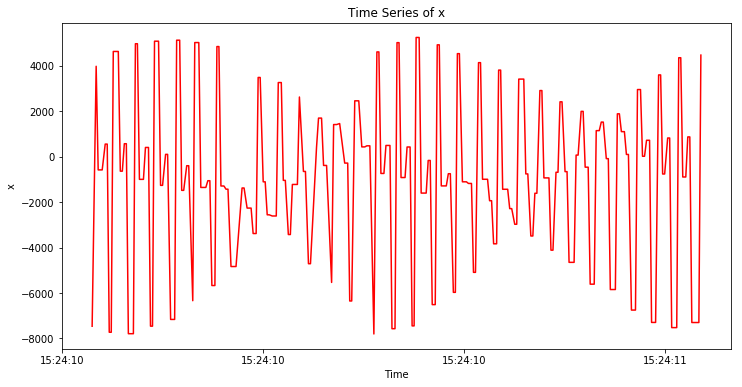

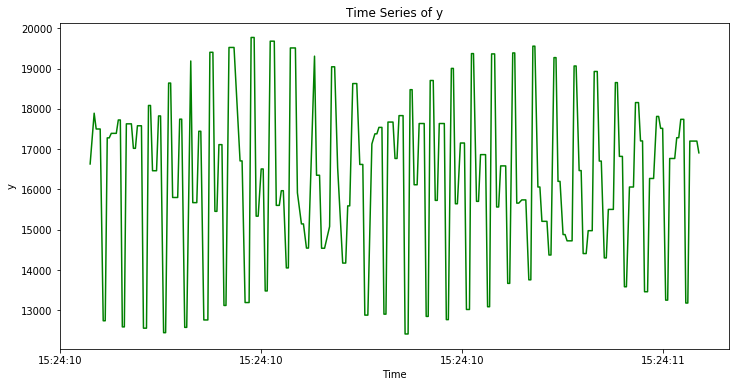

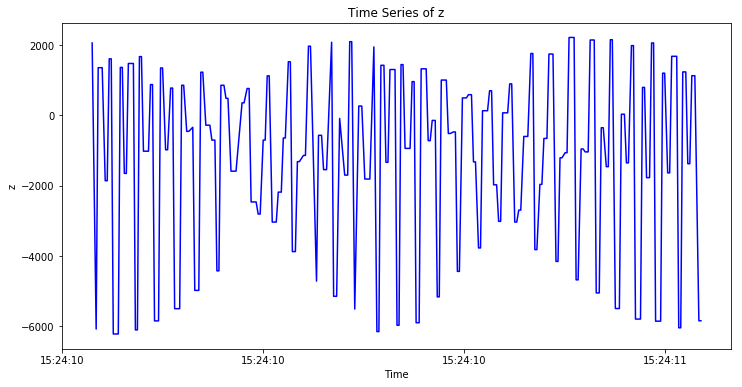

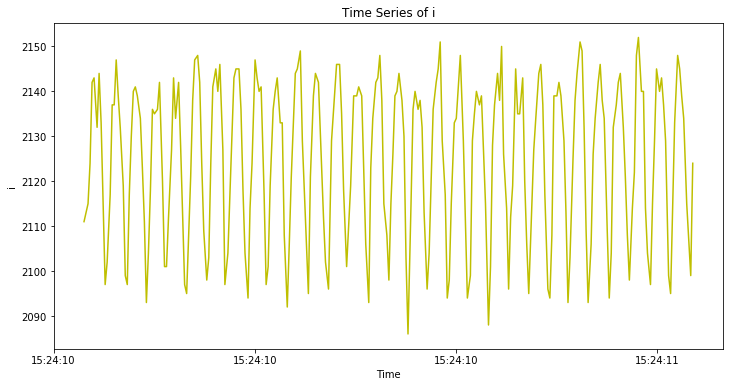

In [80]:
start_time = 0
end_time = 256
variables = df.columns.values[1:]
colors = {'x':'r', 'y':'g', 'z':'b', 'i':'y'}

for var in variables:
    
    plt.figure(figsize=(12,6))
    sns.lineplot(x='date_time', y=var, data=df[start_time:end_time], color=colors[var])
    plt.title("Time Series of " + var)
    plt.xlabel("Time")
    plt.ylabel(var)

#### EDA tutti i file

In [81]:
"""
importa tutti i file dei dati .csv, li etichetta
e li concatena in un unico dataframe
"""

all_files = glob.glob(data_path + "/*.csv")

dframe = pd.DataFrame()
f_list = []

for f in all_files:
    
    # skippa i campioni iniziali
    df = pd.read_csv(f, skiprows=1024, delimiter=',', header=None)
    df.rename(columns={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}, inplace=True)
    df['date_time'] = pd.to_datetime(df['date_time'])
    # assegna la label a ciascun sub-dataframe
    df['label'] = f[f.rfind('\\') +1]
    f_list.append(df)

# concatena i singoli df
dframe = pd.concat(f_list)

In [82]:
dframe.head(), dframe.tail()

(                date_time     x      y     z     i label
 0 2018-09-20 15:30:44.194 -3888  13068 -4300  2144     1
 1 2018-09-20 15:30:44.196  -112  15828 -4300  2136     1
 2 2018-09-20 15:30:44.199  -112  15828 -4300  2138     1
 3 2018-09-20 15:30:44.201 -7380  18088  3936  2122     1
 4 2018-09-20 15:30:44.203 -7380  18088  3936  2102     1,
                     date_time     x      y    z     i label
 24547 2018-09-20 15:28:58.065  1012  16352   28  2468     7
 24548 2018-09-20 15:28:58.067  1012  16352   28  2480     7
 24549 2018-09-20 15:28:58.069  1012  15024  780  2294     7
 24550 2018-09-20 15:28:58.071 -2012  15024  780  2070     7
 24551 2018-09-20 15:28:58.074 -2012  15024  780  1838     7)

In [83]:
dframe.label.value_counts()

5    50127
2    24552
7    24552
6    14322
3     9207
4     9207
1     9207
Name: label, dtype: int64

([<matplotlib.axis.XTick at 0x1260c251be0>,
 <a list of 7 Text xticklabel objects>)

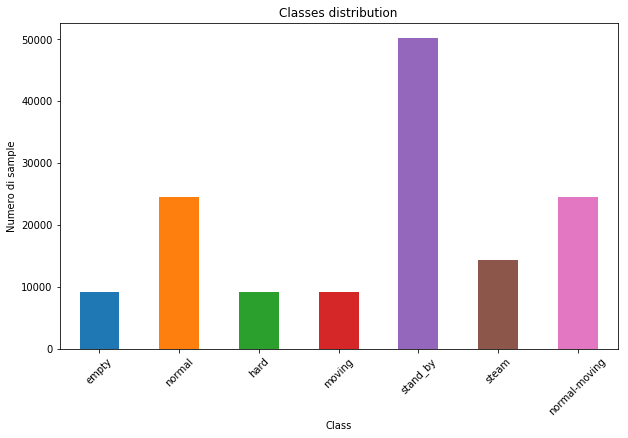

In [84]:
# plotta la distribuzione delle classi (numero di campioni per classe = modalità di funzionamento)
count_classes = pd.value_counts(dframe['label'], sort = True).sort_index()
plt.figure(figsize=(10,6))
count_classes.plot(kind = 'bar')
plt.title("Classes distribution")
plt.xlabel("Class")
plt.ylabel("Numero di sample")
#labels = {'1':'empty', '2':'normal', '3':'hard', '4':'moving', '5':'stand_by', '6':'steam', '7':'normal-moving'}
labels = ['empty', 'normal', 'hard', 'moving', 'stand_by', 'steam', 'normal-moving']
plt.xticks(range(0,7), labels, rotation=45)

In [85]:
# prende la norma delle componenti del segnale lungo i tre assi
dframe['m'] = np.sqrt(dframe['x']**2 + dframe['y']**2 + dframe['z']**2)

In [86]:
dframe.head()

,date_time,x,y,z,i,label,m
0,2018-09-20 15:30:44.194,-3888,13068,-4300,2144,1,14296.124230
1,2018-09-20 15:30:44.196,-112,15828,-4300,2136,1,16402.076942
2,2018-09-20 15:30:44.199,-112,15828,-4300,2138,1,16402.076942
3,2018-09-20 15:30:44.201,-7380,18088,3936,2122,1,19928.177037
4,2018-09-20 15:30:44.203,-7380,18088,3936,2102,1,19928.177037


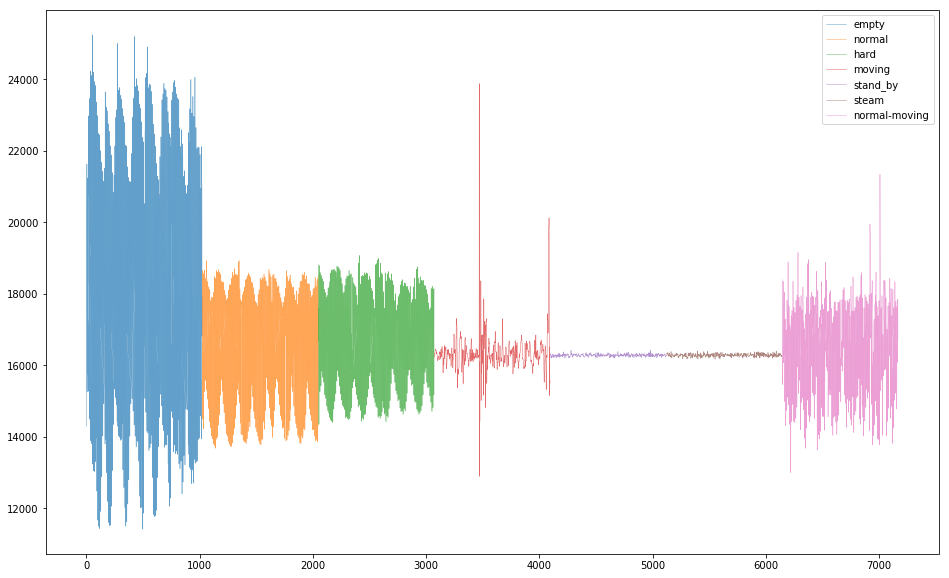

In [87]:
# plotta un certo numero di campioni per ogni modalità di funzionamento
# per visualizzare le forme d'onda 
start_sample = 0
end_sample = 1024

plt.figure(figsize=(16,10))

for c in range(1, 8):
    plt.plot(dframe[dframe['label'] == str(c)]['m'][start_sample:end_sample], 
             linewidth=.5, alpha=0.70)
    start_sample = end_sample
    end_sample = start_sample + 1024

plt.legend(labels)

### Pre-processing

#### Pre-processing FFT singolo file

In [88]:
file_name = '2_coffee-pouring-normal-20180920--15_24_10.csv'
df = pd.read_csv(data_path + file_name, delimiter=',', header=None)

In [89]:
df.rename(columns={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}, inplace=True)

In [90]:
df['date_time'] = pd.to_datetime(df['date_time'])

In [91]:
df.head(), df.tail()

(                date_time     x      y     z     i
 0 2018-09-20 15:24:10.452 -7464  16632  2060  2111
 1 2018-09-20 15:24:10.456  3976  17892 -6080  2115
 2 2018-09-20 15:24:10.458  -584  17500  1356  2124
 3 2018-09-20 15:24:10.460  -584  17500  1356  2142
 4 2018-09-20 15:24:10.462  -584  17500  1356  2143,
                     date_time     x      y     z     i
 25570 2018-09-20 15:25:11.995  1148  16772 -2528  2176
 25571 2018-09-20 15:25:11.997  1148  16772 -2528  2406
 25572 2018-09-20 15:25:12.000  1148  16456   604  2485
 25573 2018-09-20 15:25:12.002   164  16456   604  2407
 25574 2018-09-20 15:25:12.004   164  16456   604  2189)

In [92]:
SAMPLES = 128
df = df[0:SAMPLES]

end_time_idx = len(df) - 1
delta_time_sec = (df['date_time'][end_time_idx] - df['date_time'][0]).total_seconds()
N = len(df)
T = delta_time_sec/N
f = round(1/T, 2)
print("Il numero di sample selezionato è: {}".format(N))
print("L'intervallo temporale è: {} secondi".format(delta_time_sec))
print("Il periodo è: {} secondi".format(round(T, 4)))
print("La frequenza di campionamento è: {} Hz".format(f))

Il numero di sample selezionato è: 128
L'intervallo temporale è: 0.313 secondi
Il periodo è: 0.0024 secondi
La frequenza di campionamento è: 408.95 Hz


Applichiamo la trasformata veloce di Fourier per analizzare le componenti periodiche del segnale

In [93]:
f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)

In [94]:
f_values.size

64

In [95]:
fft_values_ = fft(df['x'])
fft_values = 2.0/N * np.abs(fft_values_[0:N//2])

In [96]:
fft_values.size

64

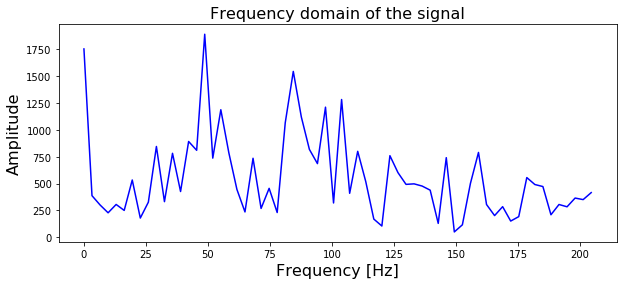

In [97]:
plt.figure(figsize=(10,4))
plt.plot(f_values, fft_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of the signal", fontsize=16)
plt.show()

Attraverso la funzione di Duarte (https://bit.ly/2P5u7Ey), individuiamo i picchi nello spazio delle frequenze che rappresentano le frequenze alle quali avvengono le oscillazioni. Tali frequenze e le relative ampiezze ci consentono di caratterizzare ciascun tipo di segnale e quindi di estrarre delle feature per l'addestramento del classificatore.

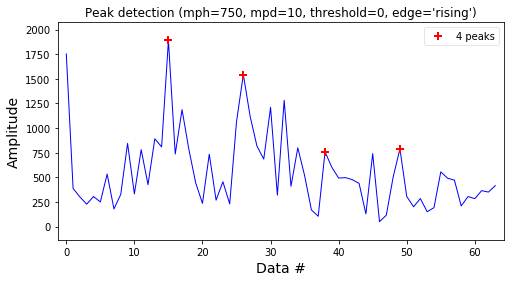

In [98]:
# NB: la scala delle ascisse non corrisponde con quella reale,
# l'indice dei picchi è invece corretto e ci consente di ottenere
# il valore di ampiezza dei picchi
ind = dpk(fft_values, mph=750, mpd=10, show=True)

In [99]:
f_values[ind]

array([ 48.68401035,  84.38561793, 123.33282621, 159.03443379])

In [100]:
fft_values[ind]

array([1889.22900957, 1543.36567487,  759.35921281,  789.39560154])

Definiamo una funzione che racchiuda gli step precedenti

In [101]:
"""
applica la FFT al segnale campionato e catturato in un file .csv
dopo averlo importato in un DataFrame di pandas;
chiede di specificare la variabile da processare [axis],
il colore del plot ed eventualmente la label
"""

def preprocess_signal_FFT(file_name, axis, start_idx, end_idx, color, label=""):
    
    # importa i dati in un DataFrame pandas
    # data_path = os.getcwd() + '\\data\\2018-09-13\\'
    data_path = os.getcwd() + '\\data\\2018-09-20\\'
    df = pd.read_csv(data_path + file_name, delimiter=',', header=None)
    df.rename(columns={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}, inplace=True)
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['m'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
    df = df[start_idx:end_idx]
    
    # applica la FFT al segnale
    start_time = 0
    end_time = len(df) - 1
    delta_time_sec = (df['date_time'][end_time] - df['date_time'][start_time]).total_seconds()
    N = len(df)
    T = delta_time_sec / N
    f = 1 / T
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(df[axis])
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    
    # plotta il segnale processato
    plt.figure()
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(f_values, fft_values, linestyle='-', color=color)
    plt.xlabel('Frequency [Hz]', fontsize=16)
    plt.ylabel('Amplitude', fontsize=16)
    plt.title("Frequency domain of the signal " + axis + " " + label, fontsize=16)
    plt.show()
    
    return f_values, fft_values

In [102]:
file_name = "3_coffee-pouring-hard-20180920--15_33_50.csv"

<Figure size 432x288 with 0 Axes>

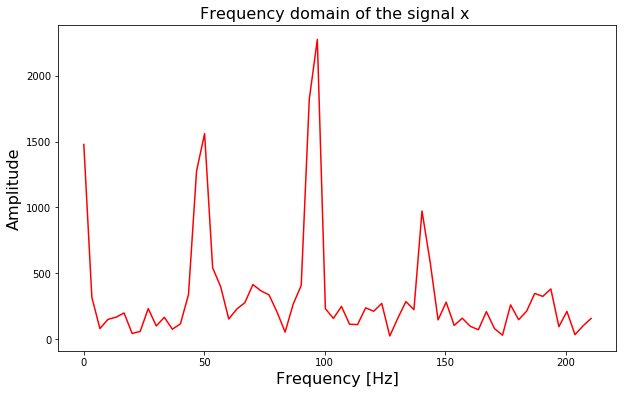

In [103]:
f_values, fft_values = preprocess_signal_FFT(file_name, 'x', start_idx=0, end_idx=128, color='red')

#### Pre-processing FFT tutti i file

In [104]:
files_list = os.listdir(data_path)

In [105]:
colors = {'1':'red', '2':'blue', '3':'green', '4':'orange', '5':'purple', '6':'cyan', '7':'pink'}
labels = {'1':'empty', '2':'normal_pouring', '3':'hard_pouring', '4':'moving', '5':'stand-by', 
          '6':'steam', '7':'normal-moving'}

<Figure size 432x288 with 0 Axes>

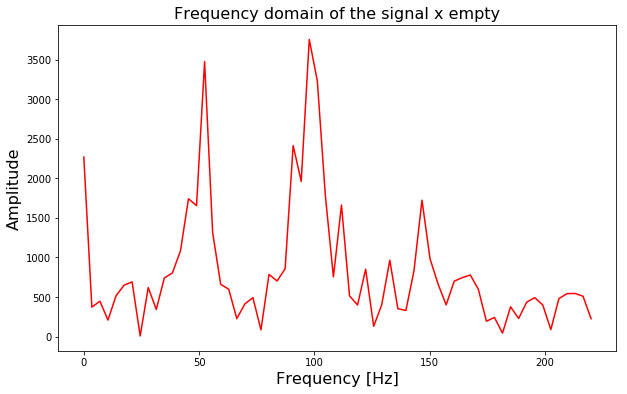

<Figure size 432x288 with 0 Axes>

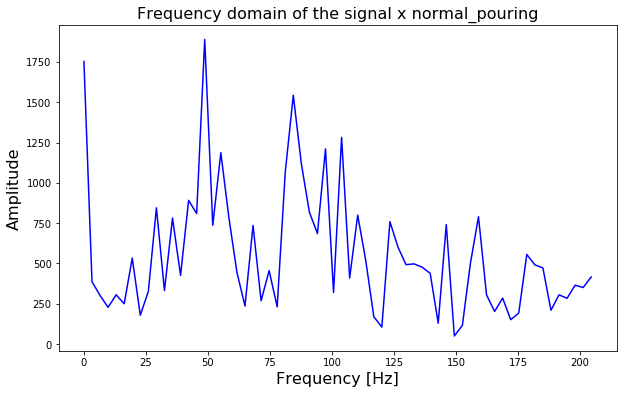

<Figure size 432x288 with 0 Axes>

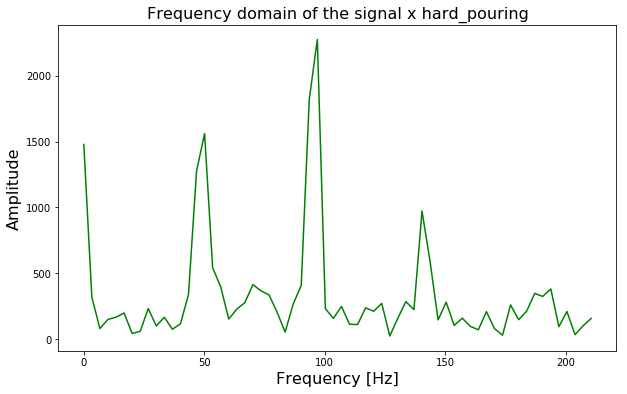

<Figure size 432x288 with 0 Axes>

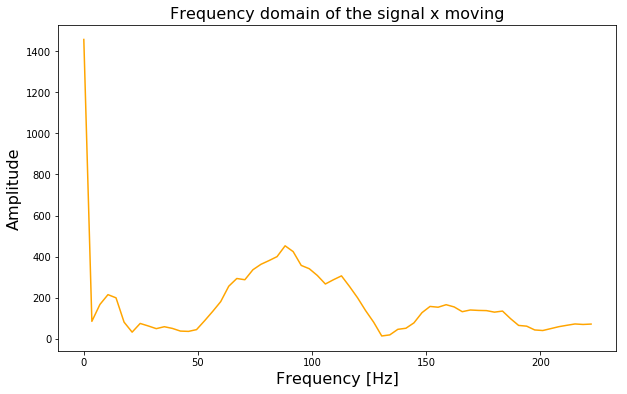

<Figure size 432x288 with 0 Axes>

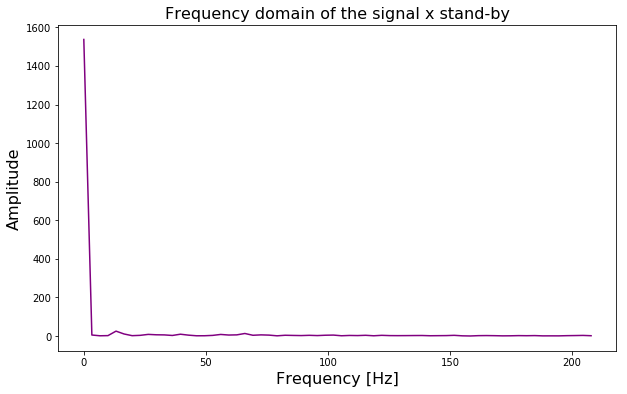

<Figure size 432x288 with 0 Axes>

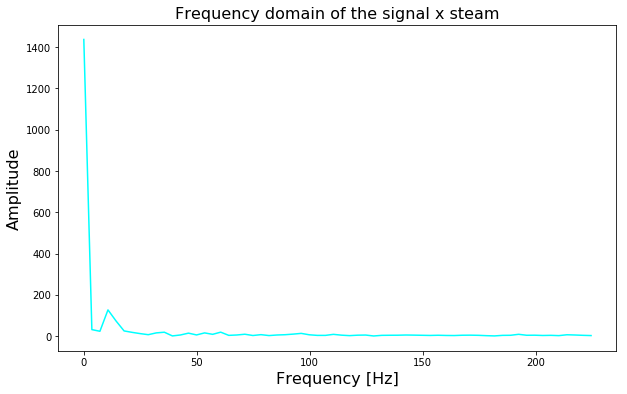

<Figure size 432x288 with 0 Axes>

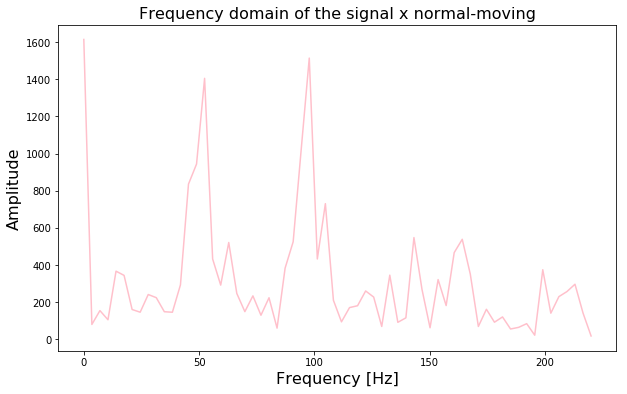

In [106]:
for f in files_list:
    file_name = f
    c = file_name[0]
    preprocess_signal_FFT(file_name, start_idx=0, end_idx=128, axis='x', color=colors[c], label=labels[c])

#### Pre-processing PSD singolo file

Similmente alla FFT, analizza lo spettro delle frequenze per calcolare la densità spettrale di potenza.

In [107]:
"""
calcola la Power Spectral Density PSD del segnale catturato in un file .csv
dopo averlo importato in un DataFrame di pandas;
chiede di specificare la variabile da processare [axis], la finestra temporale
il colore del plot ed eventualmente la label
"""

def preprocess_signal_PSD(file_name, axis, start_idx, end_idx, color, label=""):
    
    # importa i dati in un DataFrame pandas
    # data_path = os.getcwd() + '\\data\\2018-09-13\\'
    data_path = os.getcwd() + '\\data\\2018-09-20\\'
    df = pd.read_csv(data_path + file_name, delimiter=',', header=None)
    df.rename(columns={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}, inplace=True)
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['m'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
    df = df[start_idx:end_idx]
    
    # applica la PSD al segnale
    start_time = 0
    end_time = len(df) - 1
    delta_time_sec = (df['date_time'][end_time] - df['date_time'][start_time]).total_seconds()
    N = len(df)
    T = delta_time_sec / N
    f = 1 / T
    SAMPLES = end_idx-start_idx
    f_values, psd_values = welch(df[axis], fs=f, nperseg=SAMPLES)
    
    # plotta il segnale processato
    plt.figure()
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(f_values, psd_values, linestyle='-', color=color)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2 / Hz]')
    plt.title("PSD of the signal " + axis + " " + label, fontsize=16)
    plt.show()
    
    return f_values, psd_values

In [108]:
file_name = '3_coffee-pouring-hard-20180920--15_33_50.csv'

<Figure size 432x288 with 0 Axes>

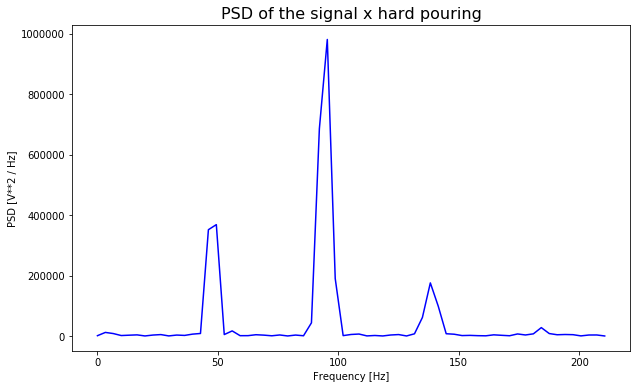

In [109]:
f_values, psd_values = preprocess_signal_PSD(file_name, start_idx=0, end_idx=128, axis='x', color='b', label='hard pouring')

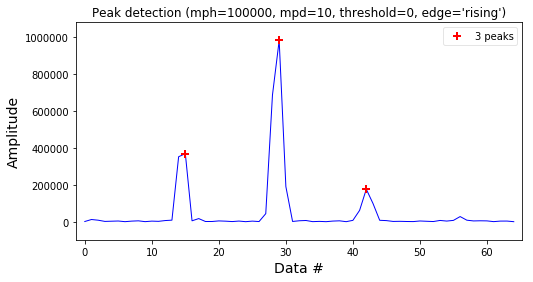

array([15, 29, 42], dtype=int64)

In [110]:
dpk(psd_values, mph=100000, mpd=10, threshold=0, show=True)

#### Pre-processing PSD tutti i file

In [111]:
files_list = os.listdir(data_path)
colors = {'1':'red', '2':'blue', '3':'green', '4':'orange', '5':'purple', '6':'cyan', '7':'pink'}
labels = {'1':'empty', '2':'normal_pouring', '3':'hard_pouring', '4':'moving', '5':'stand-by', 
          '6':'steam', '7':'normal-moving'}

<Figure size 432x288 with 0 Axes>

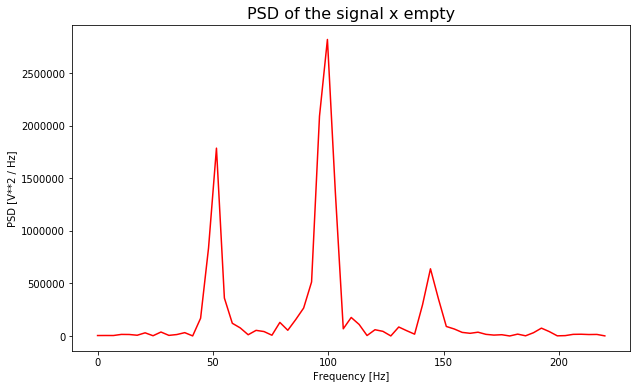

<Figure size 432x288 with 0 Axes>

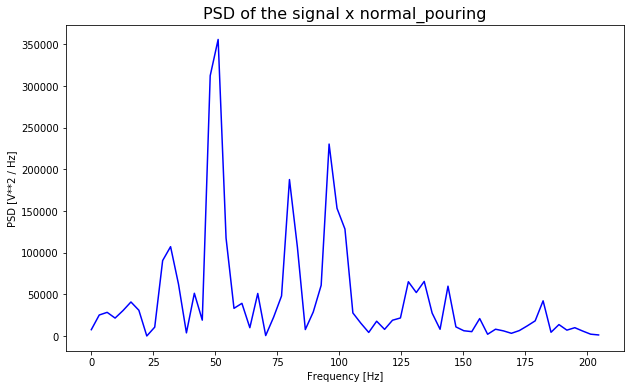

<Figure size 432x288 with 0 Axes>

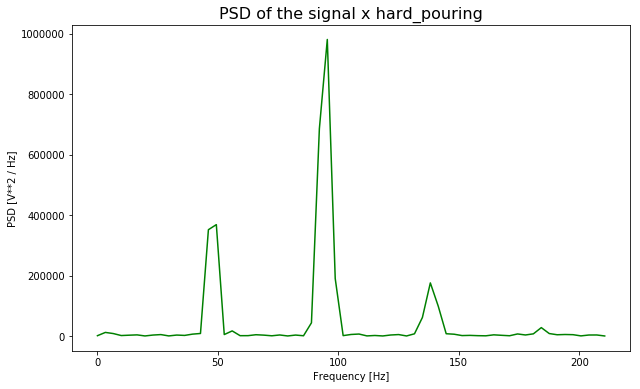

<Figure size 432x288 with 0 Axes>

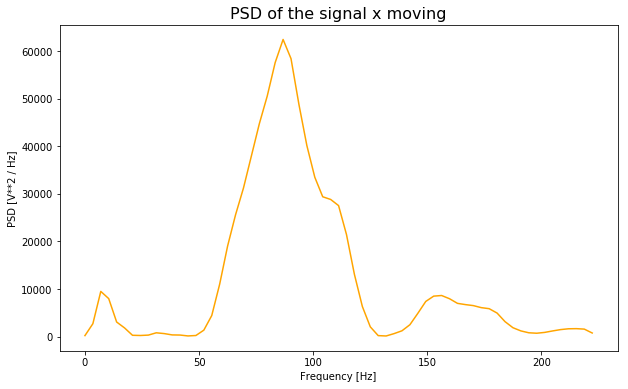

<Figure size 432x288 with 0 Axes>

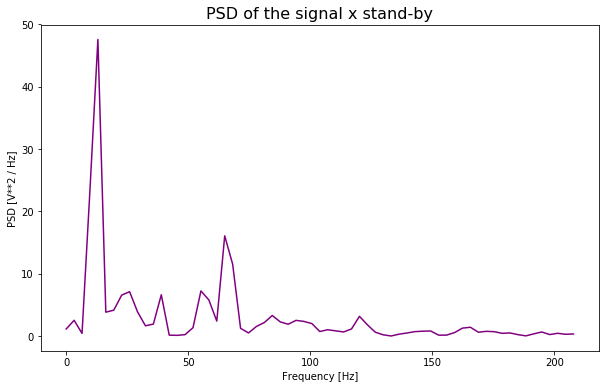

<Figure size 432x288 with 0 Axes>

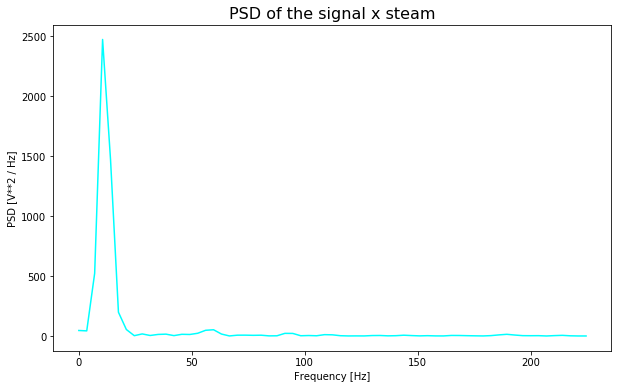

<Figure size 432x288 with 0 Axes>

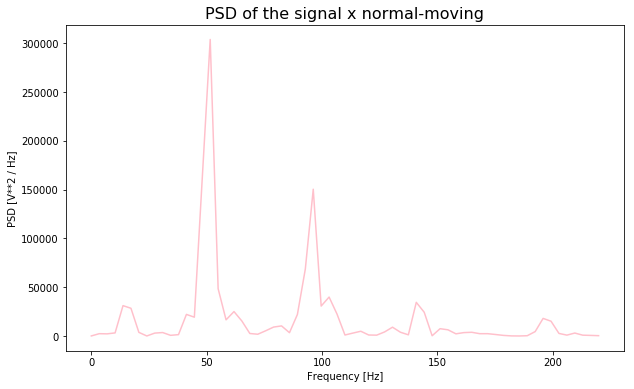

In [112]:
for f in files_list:
    file_name = f
    c = file_name[0]
    preprocess_signal_PSD(file_name, start_idx=0, end_idx=128, axis='x', color=colors[c], label=labels[c])

#### Pre-processing autocorrelation index singolo file

Calcola quanto il segnale è correlato con una versione "ritardata" del segnale stesso.

In [116]:
"""
calcola l'indice di autocorrelazione del segnale catturato in un file .csv
dopo averlo importato in un DataFrame di pandas;
chiede di specificare la variabile da processare [axis], la finestra temporale,
il colore del plot ed eventualmente la label
"""

def preprocess_signal_corr(file_name, axis, start_idx, end_idx, color, label=""):
    
    # importa i dati in un DataFrame pandas
    data_path = os.getcwd() + '\\data\\2018-09-20\\'
    df = pd.read_csv(data_path + file_name, delimiter=',', header=None)
    df.rename(columns={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}, inplace=True)
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['m'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
    df = df[start_idx:end_idx]

    delta_time_sec = (df['date_time'][end_idx -1] - df['date_time'][start_idx]).total_seconds()
    N = len(df)
    T = delta_time_sec / N
    f = 1 / T
    
    # calcola l'autocorrelation index
    result = np.correlate(df['x'], df['x'], mode='full')
    autocorr_values = result[result.size//2:]
    t_values = np.array([T * jj for jj in range(0, N)])
    
    # plotta il segnale processato
    plt.figure(figsize=(12,6))
    plt.plot(t_values[start_idx:end_idx], autocorr_values[start_idx:end_idx], linestyle='-', color=color)
    plt.xlabel('time delay [s]')
    plt.ylabel('Autocorrelation amplitude')
    plt.title("Autocorrelation of the signal " + axis + " " + label, fontsize=16)
    plt.show()
    plt.figure()

In [140]:
file_name = '2_coffee-pouring-normal-20180920--15_24_10.csv'

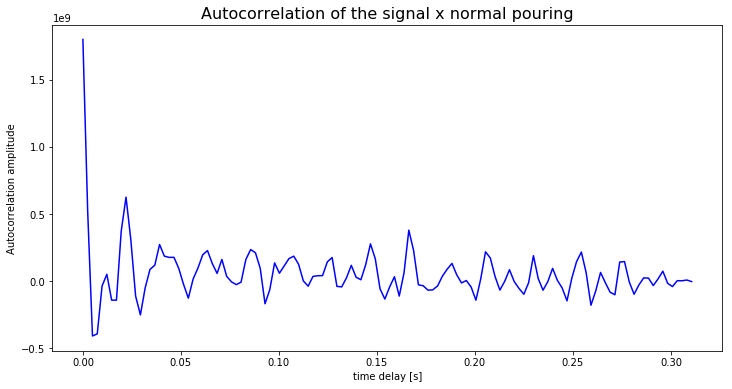

<Figure size 432x288 with 0 Axes>

In [144]:
preprocess_signal_corr(file_name, axis='x', start_idx=0, end_idx=128, color='b', label='normal pouring')

#### Pre-processing autocorrelation index tutti i file

In [119]:
files_list = os.listdir(data_path)

In [120]:
colors = {'1':'red', '2':'blue', '3':'green', '4':'orange', '5':'purple', '6':'cyan', '7':'pink'}
labels = {'1':'empty', '2':'normal_pouring', '3':'hard_pouring', '4':'moving', '5':'stand-by', 
          '6':'steam', '7':'normal-moving'}

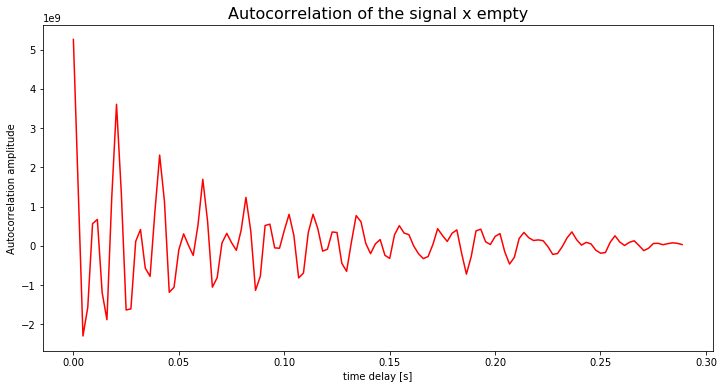

<Figure size 432x288 with 0 Axes>

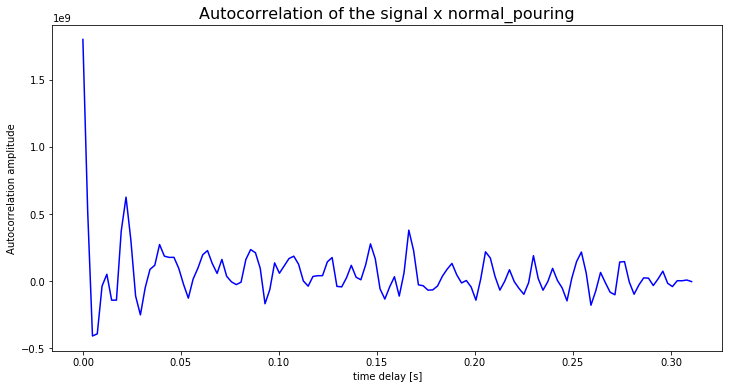

<Figure size 432x288 with 0 Axes>

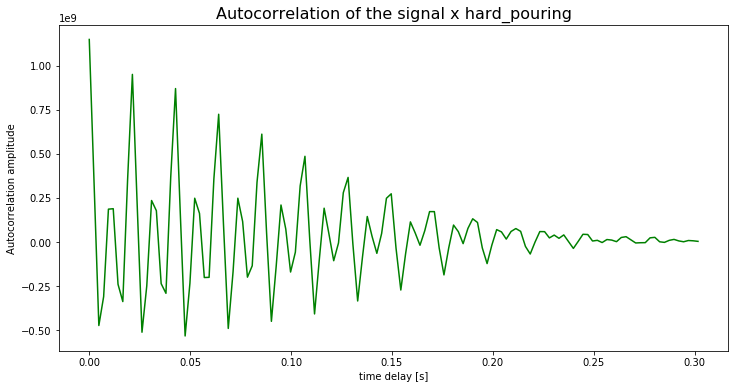

<Figure size 432x288 with 0 Axes>

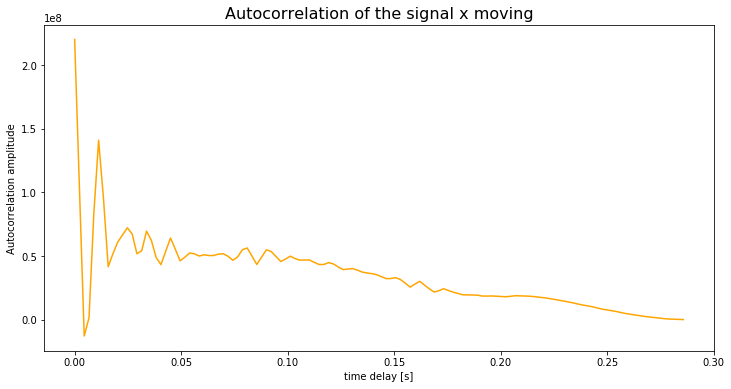

<Figure size 432x288 with 0 Axes>

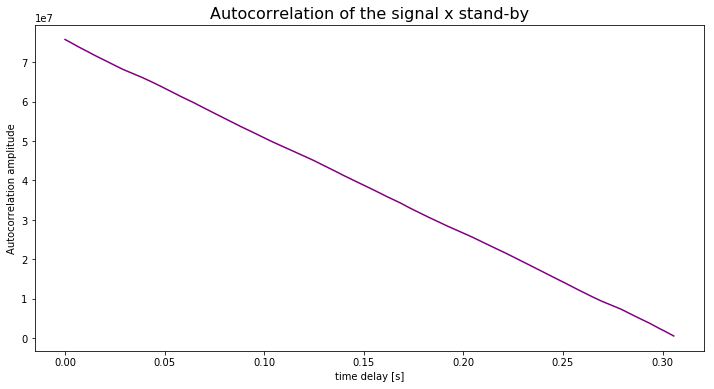

<Figure size 432x288 with 0 Axes>

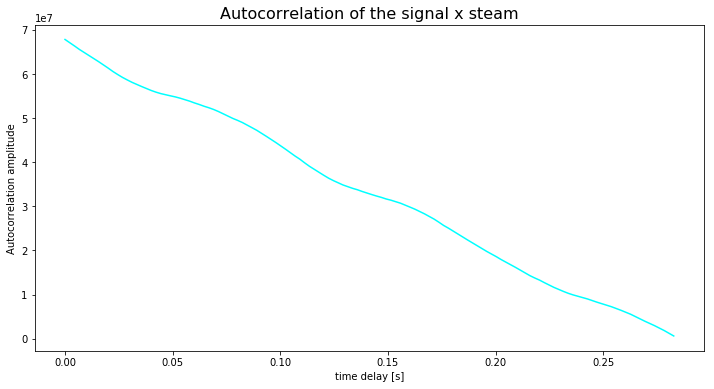

<Figure size 432x288 with 0 Axes>

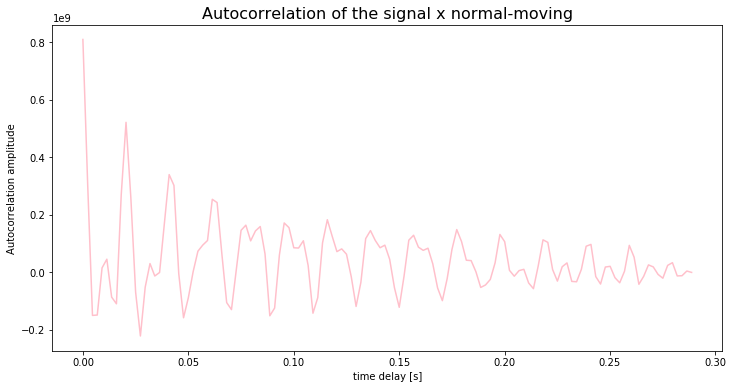

<Figure size 432x288 with 0 Axes>

In [121]:
for f in files_list:
    file_name = f
    c = file_name[0]
    preprocess_signal_corr(file_name, axis='x', start_idx=0, end_idx=128, color=colors[c], label=labels[c])

### Data preparation for modelling

In [122]:
data_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\2018-09-20\\'

In [123]:
files_list

['1_coffee-pouring-empty-20180920--15_30_41.csv',
 '2_coffee-pouring-normal-20180920--15_24_10.csv',
 '3_coffee-pouring-hard-20180920--15_33_50.csv',
 '4_coffee-moving-20180920--15_35_14.csv',
 '5_coffee-standby-20180920--15_17_26.csv',
 '6_ coffee-steam-20180920--15_37_37.csv',
 '7_coffee-pouring-normal-moving-20180920--15_27_56.csv']

In [124]:
for f in files_list:
    file_name = f
    c = file_name[0]
    df = pd.read_csv(data_path + f, delimiter=',', header=None)
    print("Il file {0} contiene {1} sample".format(f, len(df)))

Il file 1_coffee-pouring-empty-20180920--15_30_41.csv contiene 10230 sample
Il file 2_coffee-pouring-normal-20180920--15_24_10.csv contiene 25575 sample
Il file 3_coffee-pouring-hard-20180920--15_33_50.csv contiene 10230 sample
Il file 4_coffee-moving-20180920--15_35_14.csv contiene 10230 sample
Il file 5_coffee-standby-20180920--15_17_26.csv contiene 51150 sample
Il file 6_ coffee-steam-20180920--15_37_37.csv contiene 15345 sample
Il file 7_coffee-pouring-normal-moving-20180920--15_27_56.csv contiene 25575 sample


Per avere lo stesso numero di sample per ogni classe, prendiamo la classe meno numerosa e selezioniamo lo stesso numero di campioni per tutte le restanti classi. Selezioniamo poi una parte di questi esempi per il training e l'altro per il testing, scegliendo uno split ratio.

In [125]:
less_num_class = 10230

Questa funzione genara un dataset con tutte le variabili.

In [126]:
"""
importa un file .csv in un df pandas, rioganizza i nomi delle colonne
e il formato dei dati, lo divide in due df separati secondo lo split_ratio,
e li salva in due file .csv, uno per il training e l'altro per il testing
"""

def prepare_data(file_name, end_index, split_ratio):
    
    data_path = os.getcwd() + "\\data\\"
    
    labels = {'1':'empty', '2':'normal pouring', '3':'hard pouring', '4':'moving', '5':'stand-by', 
              '6':'steam', '7':'normal-moving'}
    label = file_name[0]
    split_index = int(end_index * split_ratio)
    
    df = pd.read_csv(data_path + "2018-09-20\\" + file_name, sep=',', header=None)
    df.rename(columns={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}, inplace=True)
    df['date_time'] = pd.to_datetime(df['date_time'])
    df = df[0:end_index]
    
    df_train = df[0:split_index]
    df_train.to_csv(data_path + "INPUT_TRAIN\\" + label + "_train_" + labels[label] + ".csv", sep=",",
                    index=False, encoding='utf-8')
    df_test = df[split_index:]
    df_test.to_csv(data_path+"INPUT_TEST\\" + label + "_test_" + labels[label] + ".csv", sep=",",
                   index=False, encoding='utf-8')
    
    df = pd.read_csv(data_path + "2018-09-20\\" + file_name, sep=',', header=None)

In [ ]:
#data_path = os.getcwd() + '\\data\\2018-09-20\\'

In [ ]:
# test con un singolo file
file_name = "2_coffee-pouring-normal-20180920--15_24_10.csv"
prepare_data(file_name, end_index=10230, split_ratio=0.7)

In [ ]:
# per tutti i file della cartella
for f in files_list:
    
    prepare_data(f, end_index=10230, split_ratio=0.7)

Questa funzione genera un diverso dataset per ciascuna variabile.

In [127]:
"""
importa un file .csv in un df pandas, rioganizza i nomi delle colonne
e il formato dei dati, lo divide in due df separati secondo lo split_ratio,
e per ogni variabile genera due file .csv, uno per il training e l'altro per il testing
"""

def prepare_data_split_variables(file_name, end_index, split_ratio, var_to_store):
    
    data_path = os.getcwd() + "\\data\\"
    
    labels = {'1':'empty', '2':'normal_pouring', '3':'hard_pouring', '4':'moving', '5':'stand-by', 
              '6':'steam', '7':'normal-moving'}
    label = file_name[0]
    cols={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}
    split_index = int(end_index * split_ratio)
    
    df = pd.read_csv(data_path + "2018-09-20\\" + file_name, sep=',', header=None)
    df.rename(columns={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}, inplace=True)
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['label'] = label
    df = df[0:end_index]
    
    df_train = df[0:split_index]
    #df_train_label = df_train['label'].values
    df_train = df_train.drop('label', axis=1)

    df_train.to_csv(data_path + "INPUT_TRAIN\\" + label + "_train_" + labels[label] +
                    "_" + var_to_store + "_.csv", sep=",", index=False,
                    columns=[cols[0], var_to_store], encoding='utf-8')
    df_test = df[split_index:]
    #df_test_label = df_test['label'].values
    df_test = df_test.drop('label', axis=1)


    df_test.to_csv(data_path+"INPUT_TEST\\" + label + "_test_" + labels[label] +
                    "_" + var_to_store + "_.csv", sep=",", index=False,
                    columns=[cols[0], var_to_store], encoding='utf-8')

In [ ]:
# test con un singolo file
file_name = "2_coffee-pouring-normal-20180920--15_24_10.csv"
prepare_data_split_variables(file_name, end_index=10230, split_ratio=0.7, var_to_store='x')

In [ ]:
# per tutti i file della cartella
cols={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}

for f in files_list:
    
    for i in range(1,4):
        
        prepare_data_split_variables(f, end_index=10230, split_ratio=0.7, var_to_store=cols[i])

### Data reshape

Riorganizziamo i dati secondo una struttura n-dimensionale del tipo: (num segnali, num campioni, num variabili).

In [128]:
"""
prende il segnale campionato e lo divide in un certo numero
di parti sulla base del numero di campioni selezionati [sample],
generando un df pandas di dimensioni (num segnali x num campioni)
che contiene i valori assunti dalla variabile misurata.
"""

def get_input_signals(file_name, sample):
    
    data = pd.read_csv(file_name, sep=',', header=0)
    data.drop('date_time', axis=1, inplace=True)
    
    # riduce la lunghezza del df iniziale in modo tale che sia divisibile
    # in un numero intero di parti, dato il numero di sample scelto
    lngth = len(data) // sample * sample    
    data = data[0:lngth]
    
    data.reset_index(drop=True, inplace=True)    
    split_data = np.array_split(data, len(data)//(sample))
    
    input_signals = pd.DataFrame()

    for i in range(len(split_data)):

        data_reshaped = np.reshape(split_data[i].values, (1, -1))
        input_signals = input_signals.append(data_reshaped.tolist(), ignore_index=True)
    
    return input_signals

In [ ]:
# NB: devo ancora implementare l'overlap tra i campioni, per ora i gruppi di sample sono non sovrapposti

Test su un solo file

In [129]:
os.getcwd()

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine'

In [130]:
data_path = os.getcwd() + "\\data\\INPUT_TRAIN\\"
FILE_NAME = "2_train_normal_pouring_x_.csv"

In [131]:
input_signals = get_input_signals(data_path+FILE_NAME, sample=128)

In [132]:
input_signals.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-7464,3976,-584,-584,-584,552,552,-7728,-7728,4628,...,492,492,-7572,-7572,5016,5016,-920,-920,-920,424
1,424,-7448,-7448,5244,5244,-1604,-1604,-1604,-168,-168,...,4352,4352,-896,-896,868,868,-7300,-7300,-7300,4468
2,-1316,-1316,572,572,-7288,-7288,4792,4792,-1560,-1560,...,-6668,2612,2612,2612,-264,-264,1112,1112,-7296,-7296
3,3480,3480,3480,-504,-504,856,856,-7220,-7220,4140,...,-40,672,672,672,-6240,-6240,2868,2868,-912,-912
4,1012,1012,-6492,-6492,-6492,3432,3432,-1392,-1392,948,...,1652,1652,-276,-276,556,556,-5496,-5496,2196,2196


Test su tutti i file, per una variabile

In [133]:
"""
concatena i df estratti da tutti i file (modalità di funzionamento)
per la variabile desiderata
"""

def get_all_signals_labelled(files_list, var_to_extract):
    
    all_signals =  pd.DataFrame()

    for f in files_list:

        signal = get_input_signals(f, sample=128)
        # aggiunge la colonnda label estraendola dal nome del file
        signal['label'] = f[f.rfind('\\') +1]

        all_signals = pd.concat([all_signals, signal], axis=0, ignore_index=True)
    
    return all_signals

In [134]:
var_to_check ='x'

In [135]:
files_list = glob.glob(data_path + '*_' + var_to_check + '_*')

In [136]:
files_list

['C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\1_train_empty_x_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\2_train_normal_pouring_x_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\3_train_hard_pouring_x_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\4_train_moving_x_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\5_train_stand-by_x_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\6_train_steam_x_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\7_train_normal-moving_x_.csv']

In [137]:
all_x_signals = get_all_signals_labelled(files_list, 'x')

In [138]:
all_x_signals.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
0,-5632,-5632,-5632,364,364,-6844,-6844,9672,9672,-6620,...,-4884,5836,5836,-1392,-1392,-2260,-2260,-5784,-5784,1
1,-5784,7140,7140,-2872,-2872,-1336,-1336,-6172,-6172,-6172,...,-4644,-4304,-4304,4116,4116,888,888,-3588,-3588,1
2,-4680,-4680,5336,5336,5336,-720,-720,-2608,-2608,-5452,...,6508,-6336,-6336,-2892,-2892,468,468,5108,5108,1
3,5108,-5196,-5196,-4052,-4052,2144,2144,3044,3044,-3464,...,-3064,-3064,2428,2428,-9480,-9480,7192,-3204,2300,1
4,2300,-9320,-9320,7136,7136,7136,-3272,-3272,1476,1476,...,-2160,2548,2548,-9808,-9808,6904,6904,6904,-2884,1


In [139]:
all_x_signals.tail()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
380,1044,1044,-76,-76,152,152,152,-4200,-4200,1576,...,344,228,228,-3704,164,152,152,152,216,7
381,-4252,-4252,848,848,52,52,300,300,300,-3984,...,-772,-772,-3876,-3876,-3876,-1320,-1320,72,72,7
382,72,72,-3396,-3396,-3396,-160,-160,1036,1036,912,...,-2248,-2248,944,944,248,248,248,-2316,-2316,7
383,-1088,-1088,1476,1476,492,492,-2656,-2656,-2656,-516,...,-2488,-2488,-2488,-2568,-2568,1500,1500,48,48,7
384,-1544,-1544,-1544,-1560,-1560,2204,2204,592,592,-1608,...,1444,1444,1444,96,96,-2356,-2356,-1024,-1024,7
